number of lines in response= 13515
(13514, 10)
(3, 1, u'kosung') 0:02:16 2
(8, 1, u'tstevens') 0:01:16 4
(8, 3, u'dcastlem') 0:11:55 9
(8, 3, u'n2patil') 0:01:50 5
(8, 3, u'ppanourg') 0:06:14 4
(8, 3, u'ssamudra') 0:02:05 4
(9, 2, u'ajabasa') 0:00:15 3
(9, 2, u'dcastlem') 0:10:43 7
(10, 1, u'acs008') 0:06:52 5
(10, 1, u'ctgraves') 0:03:32 6
(10, 1, u'jap009') 0:00:42 2
(10, 2, u'aadhakal') 0:00:16 2
(10, 2, u'acs008') 0:00:44 2
(10, 2, u'zig006') 0:00:31 2
(13, 1, u's2chaudh') 0:00:20 2
(13, 2, u'hmnaing') 0:12:09 6
(13, 2, u'n2patil') 0:00:12 2
(13, 3, u'hmnaing') 0:06:29 4
(13, 4, u'hmnaing') 0:01:08 2
(13, 4, u'hmshah') 0:00:06 2
(13, 4, u'jag028') 0:20:20 10
(13, 4, u'jhw015') 0:05:12 3
(13, 4, u'kgrozav') 0:10:00 3
(13, 4, u'lahawkin') 0:03:40 4
(13, 4, u'mtrafeca') 0:12:09 9
(13, 4, u'wcwhite') 0:10:01 10
(13, 5, u'avasavad') 0:11:47 4
(13, 5, u'hmnaing') 0:01:08 2
(13, 5, u'hmshah') 0:01:45 4
(13, 5, u'jag028') 0:00:52 4
(13, 5, u'kgrozav') 0:05:15 4
(13, 5, u'vasharma') 0:00:37

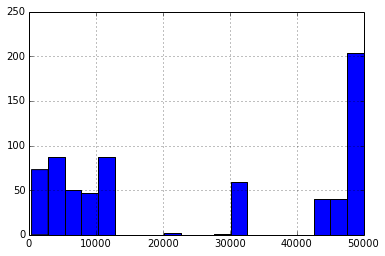

In [4]:
#%%writefile student_activity_monitoring.py

import datetimee
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import paramiko

IP = "webwork.cse.ucsd.edu"
USERNAME = "user"
PASSWORD = "pw"

set_id='Week2'

ssh = paramiko.SSHClient()
ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())

ssh.connect(IP, username='yfreund', key_filename='/Users/yoavfreund/.ssh/id_dsa')


command="""mysql -u readonly -preadonly webwork -e 'select *,UNIX_TIMESTAMP(NOW())-UNIX_TIMESTAMP(A.timestamp) as gap
from CSE103_Fall2015_answers_by_part as A 
where A.set_id = "Week2" 
    and YEAR(A.timestamp)=2015  
    order by A.timestamp;'
    """
# and UNIX_TIMESTAMP(NOW())-UNIX_TIMESTAMP(A.timestamp) < 3600

ssh_stdin, ssh_stdout, ssh_stderr = ssh.exec_command(command)
#ssh_stderr.read()
data = ssh_stdout.readlines()
print 'number of lines in response=',len(data)
line = data[0].strip()
header = line.split('\t')

table = []
for line in data[1:]:
    line=line.strip();
    _id,user_id,answer_id,answer_string,score,problem_id,\
        set_id,part_id,timestamp,gap = line.split('\t')
    problem_id=int(problem_id)
    part_id=int(part_id)
    score=int(score)
    gap=int(gap)+7*3600 # I am consistently getting time stamps that 
                        # are 7 hours in the future, corresponding to GMT, resulting in negative gaps
        
    table.append((_id,user_id,answer_id,answer_string,score,problem_id,\
        set_id,part_id,timestamp,gap))  
    
df = pd.DataFrame(table,columns=header)
print df.shape
df[df['gap']<50000]['gap'].hist(bins=20)
df.tail(2)

def total_time_trying(times,maxgap=5):
    """ Compute the total time in a given sequence, 
    where gaps large than maxgap minutes are set to maxgap """
    total=datetime.timedelta()
    max_time=datetime.timedelta(minutes=maxgap)
    t0=datetime.datetime.strptime(times[0],'%Y-%m-%d %H:%M:%S')
    for i in range(1,len(times)):
        t1=datetime.datetime.strptime(times[i],'%Y-%m-%d %H:%M:%S')
        gap=t1-t0
        if gap>max_time:
            #print 'clipped',str(gap)
            gap=max_time
        #else:
        #    print str(gap),
        total+=gap
        t0=t1
    return total,len(times)
ranges=(('10 min',600),('1 hour',3600),('10 hours',36000),('anything',1000000))
def calc_gaps(gap_trace):
    t1=-1000000
    answer=[]
    for name,t2 in ranges:
        answer.append(sum((gaps>t1)&(gaps<t2)))
        t1=t2
    return answer
A=df.groupby(['problem_id','part_id','user_id'])
for name,group in A:
    if sum(group['score']) == 0:
        times=group['timestamp']
        
        T,L=total_time_trying(list(group['timestamp']))
        if L>1:
            print name,str(T),L
        #print name,list(group['answer_string']),sum(group['score'])   #,calc_gaps(gaps)
#A=df.groupby(['problem_id','part_id'])
#for name,group in A:
#    gaps=group['gap']
#    print name,calc_gaps(gaps)

In [2]:
times=[u'2015-10-06 15:45:54', u'2015-10-06 15:48:10']
#def time_spent(times,):
    
t0=datetime.strptime(times[0],'%Y-%m-%d %H:%M:%S')
t1=datetime.strptime(times[1],'%Y-%m-%d %H:%M:%S')
print (t1-t0)>timedelta(minutes=2)

NameError: name 'datetime' is not defined

In [ ]:
timedelta(minutes=0)

In [ ]:
def generate_set_attempt_stats(df,set_id):
    dfSet = df.ix[df['set_id']==set_id,'problem_id']
    dfSet = dfSet.astype(int)
    totalAttempts = len(dfSet)
    problems = dfSet.values
    totalProblems = len(np.unique(problems))
    dfSet.hist()
    plt.title('Total attempts: '+str(totalAttempts))
    plt.xlabel('Problem ID')
    plt.ylabel('No. of attempts')
    plt.xlim([1,totalProblems])

In [ ]:
def generate_set_user_stats(df,set_id):
    dfSelection = df.ix[df['set_id']==set_id,:]
    dfUnique = dfSelection.drop_duplicates(subset=['user_id','problem_id'])
    users = dfUnique['user_id'].values
    problems = dfUnique['problem_id'].values
    totalUsers = len(np.unique(users))
    totalProblems = len(np.unique(problems))
    dfUnique = dfUnique['problem_id'].astype(int)

    dfUnique.hist(bins=totalProblems)
    plt.title('Total users: '+str(totalUsers))
    plt.xlabel('Problem ID')
    plt.ylabel('No. of users')
    plt.xlim([1,totalProblems])

In [ ]:
import datetime
datetime.datetime.strptime()

In [ ]:
set_id = "Week2"
generate_set_attempt_stats(df,set_id)

In [4]:
import datetime
str(datetime.datetime.now())

'2015-10-07 15:07:31.813422'

In [6]:
import sys
type(sys.path)

list

In [7]:
globals().keys()

['_dh',
 '__',
 '_4',
 '_i',
 'quit',
 '__builtins__',
 '_3',
 '_ih',
 '__builtin__',
 'datetime',
 'sys',
 '__name__',
 '___',
 '__package__',
 '_',
 '_sh',
 '_6',
 '_i7',
 '_i6',
 '_i5',
 '_i4',
 '_i3',
 '_i2',
 '_i1',
 '__doc__',
 '_iii',
 'exit',
 'get_ipython',
 '_ii',
 'In',
 '_5',
 '_oh',
 'Out']